In [1]:
# Import libraries

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, Xception


# Check TensorFlow version
print(tf.__version__)
# check tensorflow GPU
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

2.16.2
Num GPUs Available:  1


In [2]:
# ! /bin/bash
# ! kaggle datasets download hamzaboulahia/hardfakevsrealfaces

In [3]:
# ! unzip hardfakevsrealfaces.zip

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data

images_id label
0       real_1  real
1      real_10  real
2     real_100  real
3     real_101  real
4     real_102  real
...        ...   ...
1284   fake_95  fake
1285   fake_96  fake
1286   fake_97  fake
1287   fake_98  fake
1288   fake_99  fake

[1289 rows x 2 columns]

In [6]:
data['images_id'] = data['label'] + r"/" + data['images_id'] + '.jpg'

In [7]:
data

images_id label
0       real/real_1.jpg  real
1      real/real_10.jpg  real
2     real/real_100.jpg  real
3     real/real_101.jpg  real
4     real/real_102.jpg  real
...                 ...   ...
1284   fake/fake_95.jpg  fake
1285   fake/fake_96.jpg  fake
1286   fake/fake_97.jpg  fake
1287   fake/fake_98.jpg  fake
1288   fake/fake_99.jpg  fake

[1289 rows x 2 columns]

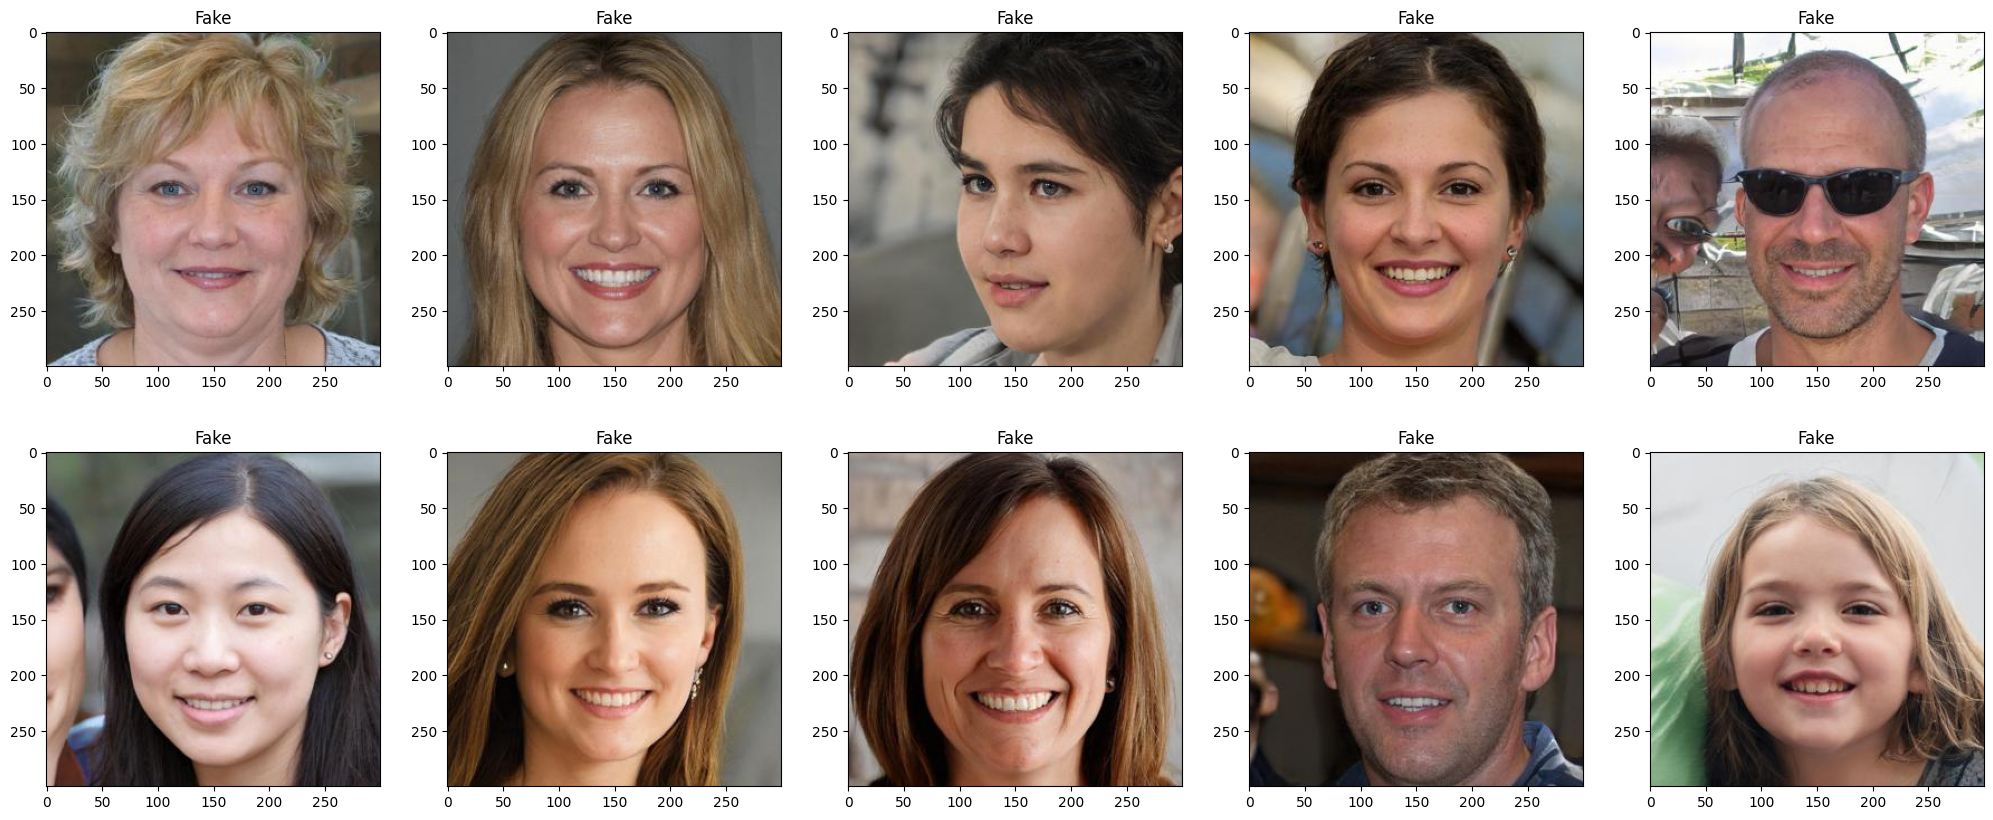

In [8]:
# show 10 images of fake faces
fake_images = glob.glob('fake/*.jpg')
fake_images = np.random.choice(fake_images, 10, replace=False)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
n = 0
for i in range(2):
  for j in range(5):
    img = plt.imread(fake_images[n])
    ax[i][j].imshow(img)
    ax[i][j].set_title('Fake')
    n += 1

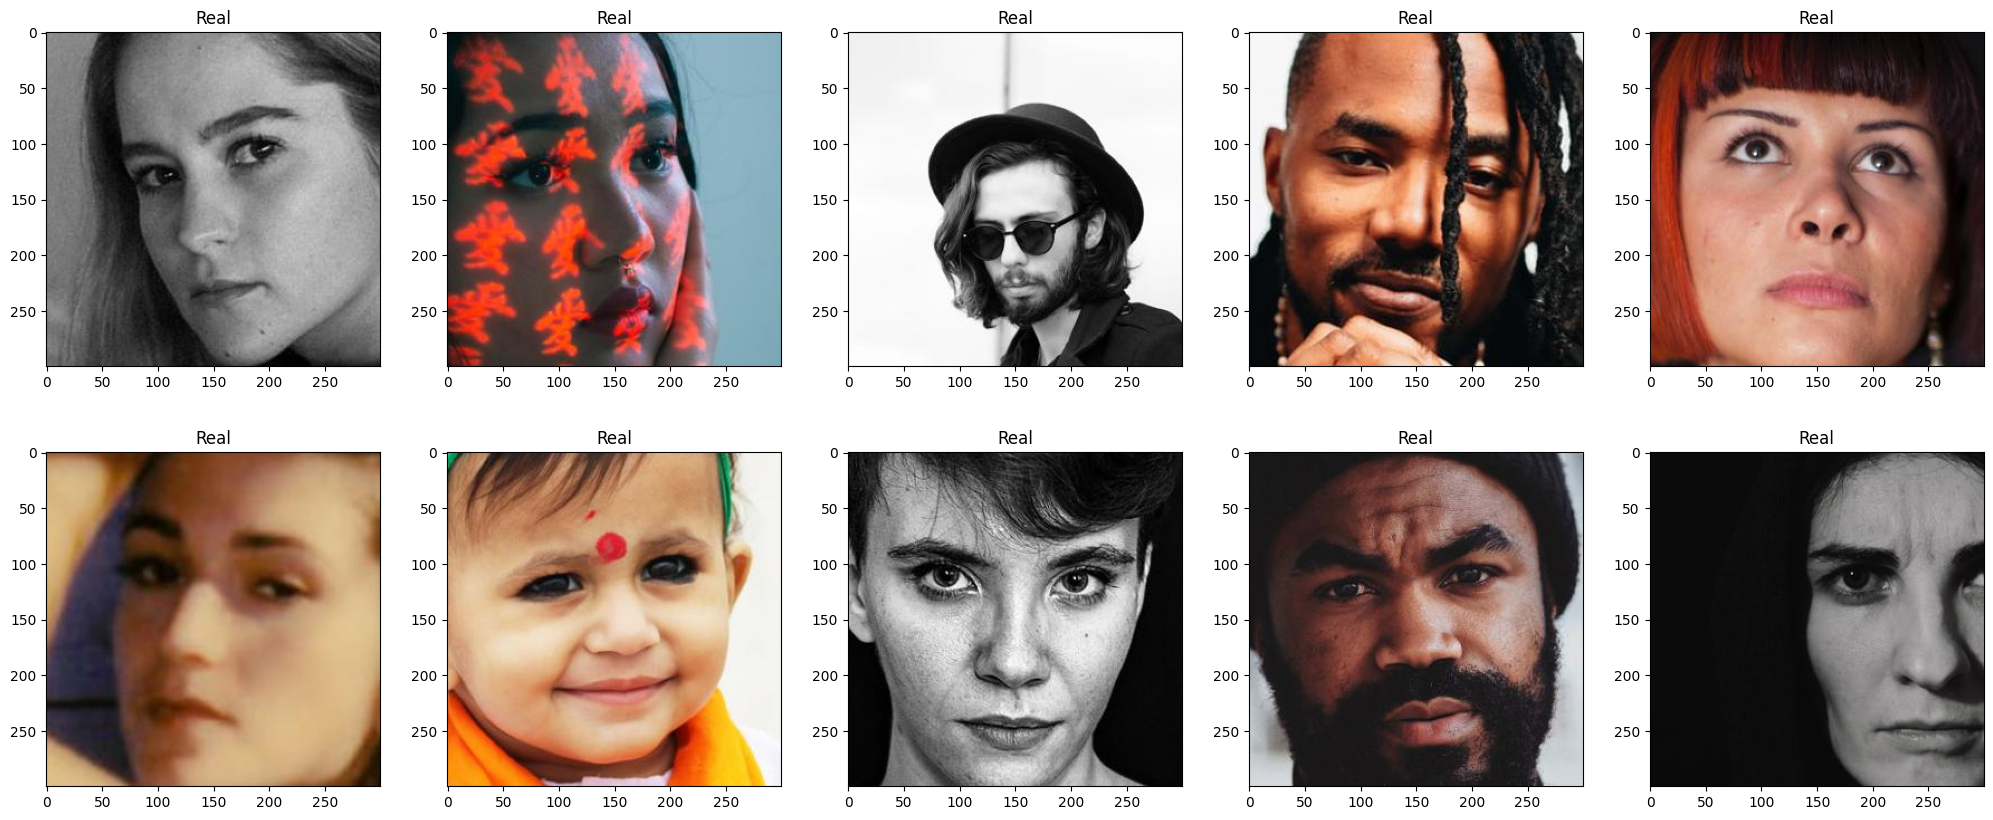

In [9]:
#show real faces
real_images = glob.glob('real/*.jpg')
real_images = np.random.choice(real_images, 10, replace=False)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
n = 0
for i in range(2):
  for j in range(5):
    img = plt.imread(real_images[n])
    ax[i][j].imshow(img)
    ax[i][j].set_title('Real')
    n += 1

In [10]:
# split train test
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
# Example of how to split dataset into train-set and validation-set using `flow_from_dataframe`

imgen2 = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.4)
train2 = imgen2.flow_from_dataframe(train_df,
                                    x_col='images_id',
                                    y_col='label',
                                    target_size=(400,400),
                                    class_mode='binary',
                                    subset='training',
                                    shuffle=True,
                                    seed=2)
val2 = imgen2.flow_from_dataframe(train_df,
                                  x_col='images_id',
                                  y_col='label',
                                  target_size=(400,400),
                                  class_mode='binary',
                                  subset='validation',
                                  shuffle=True,
                                  seed=2)

Found 619 validated image filenames belonging to 2 classes.
Found 412 validated image filenames belonging to 2 classes.


In [12]:
train2.class_indices

{'fake': 0, 'real': 1}

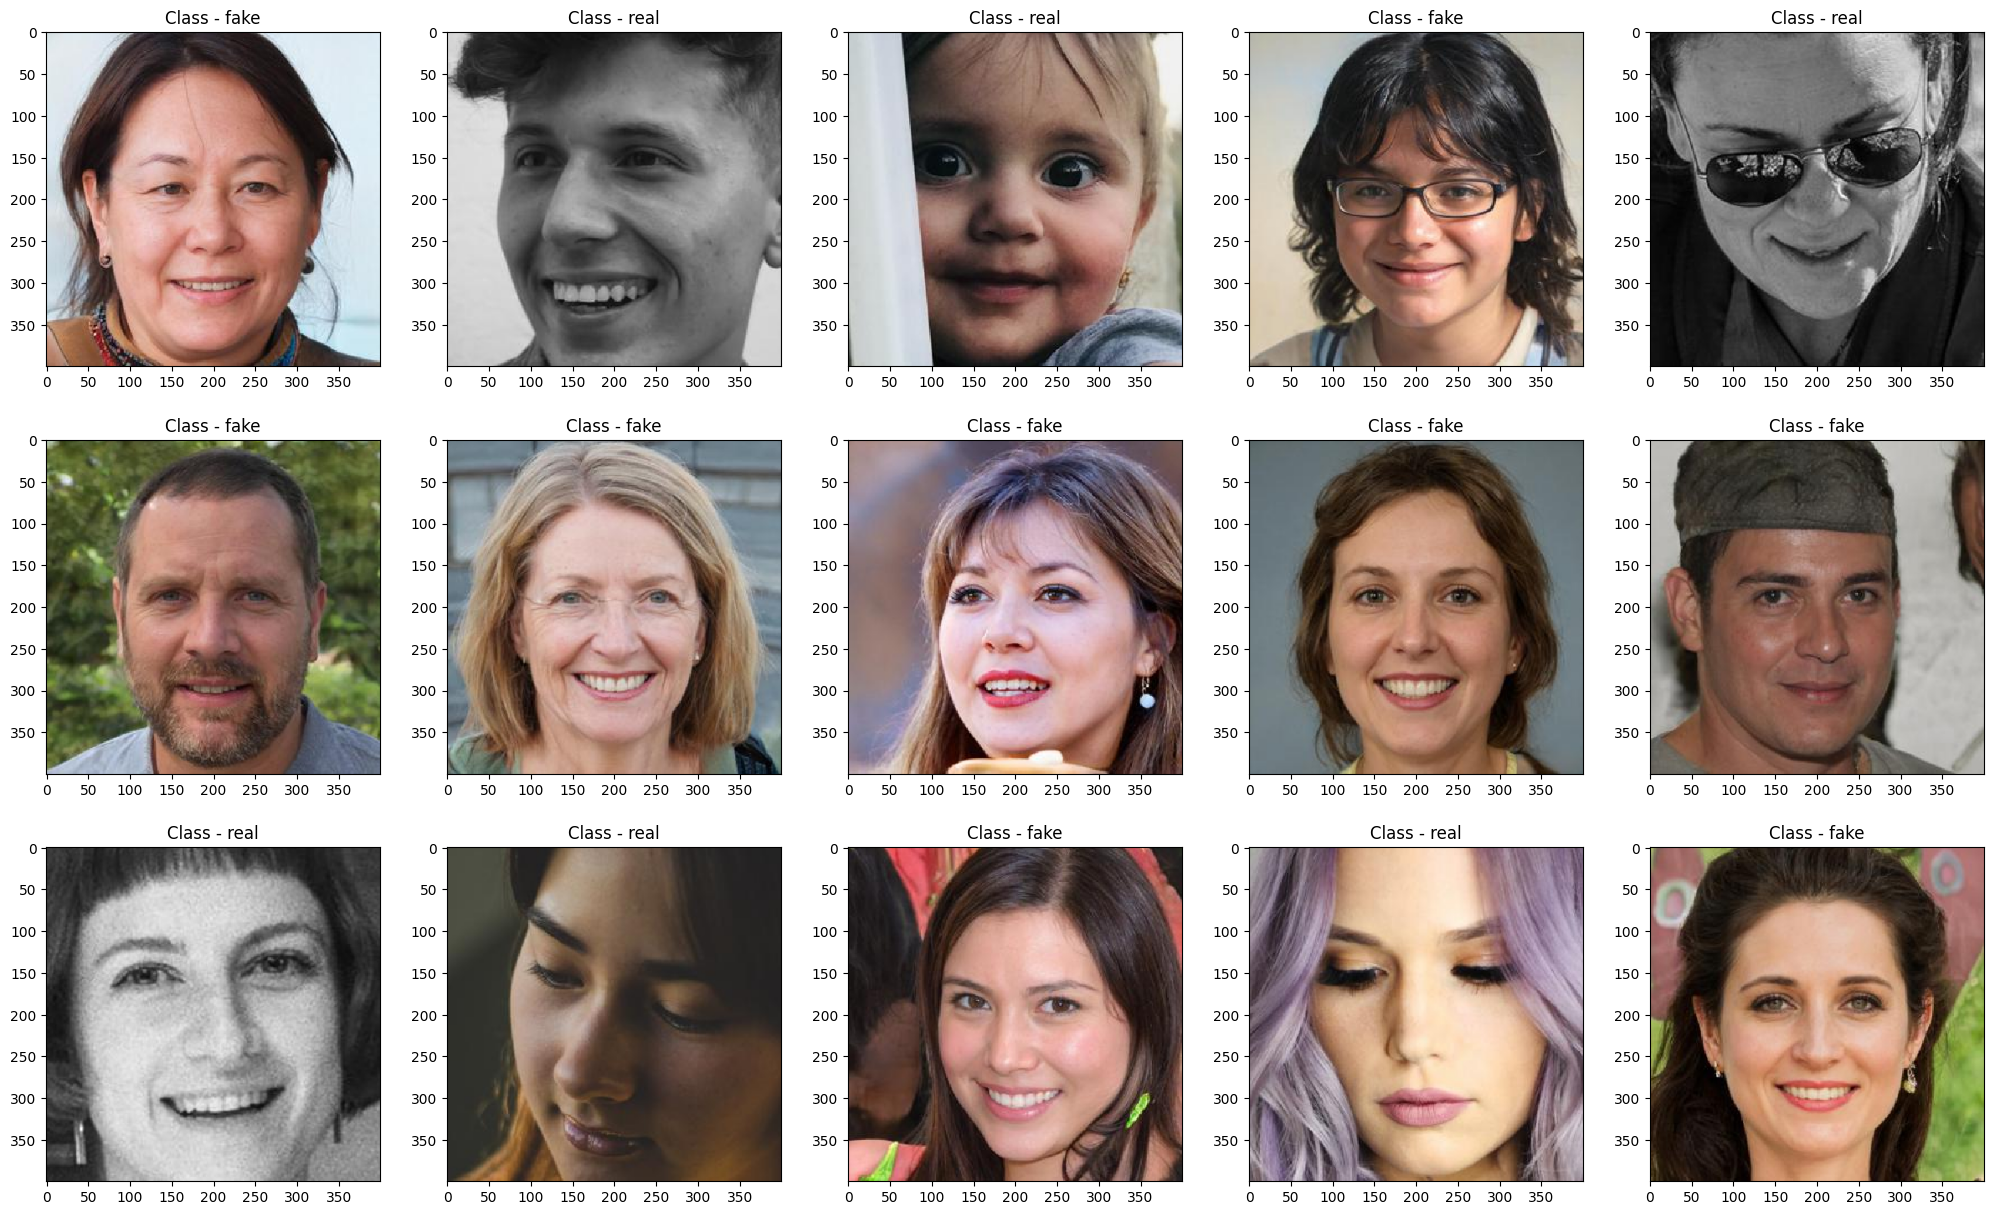

In [13]:
# Show images of train-set

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(25,15))
n = 0

for i in range(3):
  for j in range(5):
    img = train2[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(np.where(train2[0][1][n]==0 , 'fake', 'real')))
    n += 1

# Model

In [14]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
img_height = 400
img_width = 400

In [16]:
# Create Sequential API model

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(2, 2))
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(BatchNormalization())

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))  # Another Dropout layer

model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))  # Use sigmoid for binary classification

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/Users/hacktiv8/anaconda3/envs/tensorflow_gpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-30 13:08:15.513497: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-30 13:08:15.513575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-30 13:08:15.513585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-30 13:08:15.513789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-30 13:08:15.513809: I tensorflow/core/common_runtime/pluggable_device/pluggable

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,929 (1.12 MB)

 Trainable params: 291,905 (1.11 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [17]:
history = model.fit(train2, epochs=30, validation_data=val2, batch_size=64)

Epoch 1/30


/Users/hacktiv8/anaconda3/envs/tensorflow_gpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-30 13:08:16.571124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 597ms/step - accuracy: 0.5416 - loss: 1.0968 - val_accuracy: 0.4563 - val_loss: 7.5403
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 522ms/step - accuracy: 0.4861 - loss: 1.2315 - val_accuracy: 0.5485 - val_loss: 1.2731
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.5483 - loss: 0.9490 - val_accuracy: 0.5655 - val_loss: 1.7670
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.5646 - loss: 0.9970 - val_accuracy: 0.5607 - val_loss: 1.2274
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - accuracy: 0.5286 - loss: 0.9467 - val_accuracy: 0.4563 - val_loss: 1.3455
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.5586 - loss: 1.0866 - val_accuracy: 0.4660 - val_loss: 1.0927
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - accuracy: 0.5290 - loss: 1.3655 - val_accuracy: 0.4539 - val_loss: 1.7355
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.5508 - loss: 1.3293 - val_accuracy: 0.444

<Axes: >

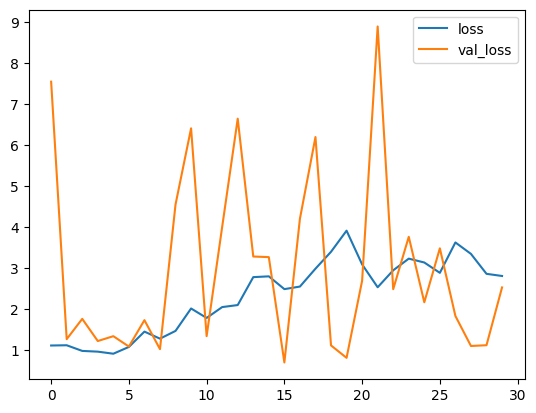

In [18]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

## Pretrainede Model

In [23]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
# EfficientNetB0 model

base_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
base_model.trainable = False



model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(BatchNormalization())

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))  # Another Dropout layer

model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))  # Use sigmoid for binary classification

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 13, 13, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,839,076 (18.46 MB)

 Trainable params: 788,481 (3.01 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

In [25]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, restore_best_weights=True)

In [26]:
history_2 = model.fit(train2, epochs=30, validation_data=val2, batch_size=64, callbacks=[early_stopping])
history_df_2 = pd.DataFrame(history_2.history)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.8456 - loss: 0.4335 - val_accuracy: 0.9587 - val_loss: 0.1057
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9585 - loss: 0.1526 - val_accuracy: 0.9612 - val_loss: 0.0999
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9808 - loss: 0.0708 - val_accuracy: 0.9782 - val_loss: 0.0642
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9850 - loss: 0.0408 - val_accuracy: 0.9563 - val_loss: 0.1126
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9946 - loss: 0.0272 - val_accuracy: 0.9733 - val_loss: 0.0980
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9898 - loss: 0.0195 - val_accuracy: 0.9733 - val_loss: 0.0935
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9940 - loss: 0.0334 - val_accuracy: 0.9684 - val_loss: 0.1092
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9950 - loss: 0.0145 - val_accuracy: 0.9612 - val_loss:

<Axes: >

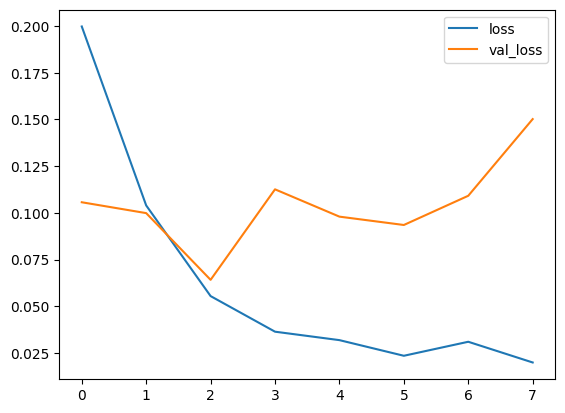

In [27]:
history_df_2[['loss', 'val_loss']].plot()

In [ ]:
model.predict(test)